## Setup
NOTE: this notebook is more advanced than the ViT one because it uses tensorflow data objects which are smarter and easier to work with. This took some time, so I can also do this for ViT later.

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import cv2
import os
import matplotlib.pyplot as plt
import datetime

2023-08-03 18:23:34.946876: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/andyd/miniconda3/envs/nlp/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Prepare the data

In [3]:
# loading all images
images = []
labels = []
root = './dataset/merged/'
for folder in os.listdir(root):
    for image in os.listdir(os.path.join(root, folder)):
        images.append(cv2.imread(os.path.join(root, folder, image)))
        labels.append(folder)

In [4]:
y_normal = pd.DataFrame(labels)
y_normal[0].unique()
y = pd.get_dummies(y_normal)
y.head()

,0_Bengin cases,0_Malignant cases,0_Normal cases
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


the dataset creation cell threw a warning aboout ragged sequences here, so i'm gonna detour here

In [5]:
# verify sizes of all images.
resolution = set()
count = 0
for image in images:
    if image.shape != (512, 512, 3):
        resolution.add(image.shape)
        count += 1
print(str(resolution) + '\n' + f"Number of irregular images: {count}")

{(512, 801, 3), (512, 623, 3), (404, 511, 3), (331, 506, 3)}
Number of irregular images: 61


#FIXTHIS 61 images have irregular resolutions. Removing them for now

In [6]:
filtimg = list()

for idx in range(len(images)):
    if images[idx].shape == (512, 512, 3):
        filtimg.append(images[idx])
    else:
        y.drop(idx, axis='rows', inplace=True)

if (len(images) - len(filtimg)) == 61:
    images = filtimg

In [7]:
dataset = np.array(images)

dataset.shape[0] == y.shape[0]

True

In [8]:
y.shape

(1036, 3)

In [9]:
num_classes = np.unique(y).shape[0]
input_shape = (512, 512, 3)

x_train, x_test, y_train, y_test = train_test_split(dataset, y, test_size = 0.25,
                                                    shuffle=True)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (777, 512, 512, 3) - y_train shape: (777, 3)
x_test shape: (259, 512, 512, 3) - y_test shape: (259, 3)


# Hyperparameter initialisation and Dataset finalization

In [10]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
img_height = 180
img_width = 180
num_epochs = 15
image_size = 56  # We'll resize input images to this size
patch_size = 8  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


## Using tensorflow dataset objects moving forward

In [11]:
# importing the training split
train_ds = tf.keras.utils.image_dataset_from_directory(
  root,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1097 files belonging to 3 classes.
Using 878 files for training.


2023-08-03 18:23:57.742124: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-03 18:23:57.794015: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-03 18:23:57.794140: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-03 18:23:57.796579: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-03 18:23:57.796623: I tensorflow/compile

In [12]:
# importing the validation split
val_ds = tf.keras.utils.image_dataset_from_directory(
  root,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1097 files belonging to 3 classes.
Using 219 files for validation.


In [13]:
# testing for class names presence
class_names = train_ds.class_names
print(class_names)

['Bengin cases', 'Malignant cases', 'Normal cases']


In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [15]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds


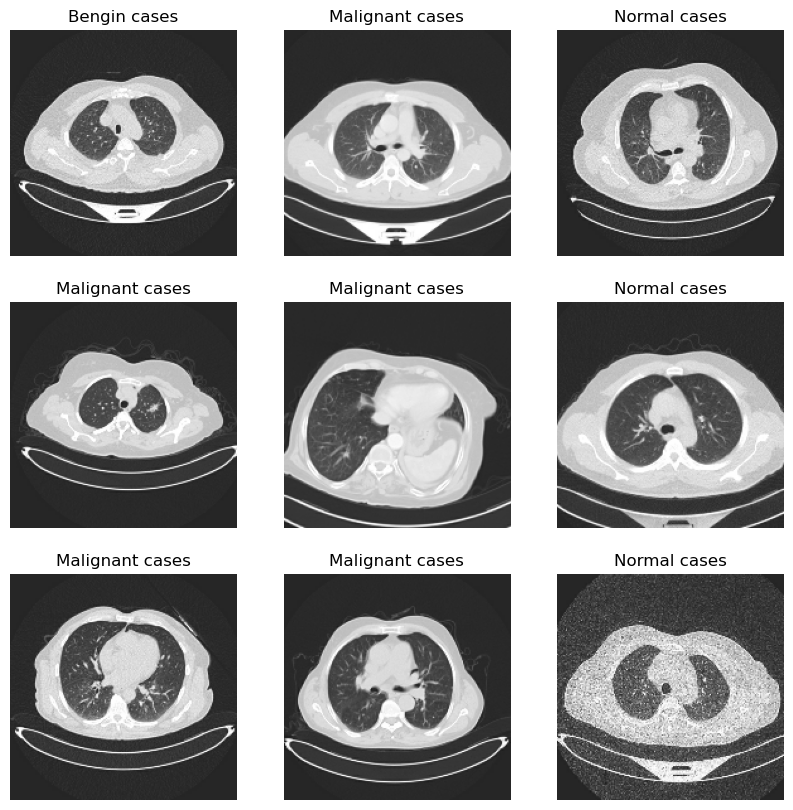

In [16]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [17]:
%reload_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [18]:
num_classes = 3

model = tf.keras.Sequential([
 # tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

fit = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15,
  callbacks=[tensorboard_callback]
)

Epoch 1/15


2023-08-03 18:24:05.454205: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2023-08-03 18:24:06.171994: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-03 18:24:06.382721: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9c0c006140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-03 18:24:06.382766: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 Super, Compute Capability 7.5
2023-08-03 18:24:06.387074: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-03 18:24:06.588872: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-03 18:24:06.641911: I ./tensorflow/compiler/jit/devic

28/28 [==============================] - 7s 82ms/step - loss: 20.5798 - accuracy: 0.7062 - val_loss: 0.8027 - val_accuracy: 0.7397
Epoch 2/15
28/28 [==============================] - 2s 65ms/step - loss: 0.2801 - accuracy: 0.9077 - val_loss: 0.2358 - val_accuracy: 0.9132
Epoch 3/15
28/28 [==============================] - 2s 63ms/step - loss: 0.0571 - accuracy: 0.9886 - val_loss: 0.0900 - val_accuracy: 0.9772
Epoch 4/15
28/28 [==============================] - 2s 54ms/step - loss: 0.0189 - accuracy: 0.9932 - val_loss: 0.0909 - val_accuracy: 0.9726
Epoch 5/15
28/28 [==============================] - 2s 57ms/step - loss: 0.0234 - accuracy: 0.9920 - val_loss: 0.1567 - val_accuracy: 0.9680
Epoch 6/15
28/28 [==============================] - 2s 56ms/step - loss: 0.0411 - accuracy: 0.9897 - val_loss: 0.1519 - val_accuracy: 0.9680
Epoch 7/15
28/28 [==============================] - 2s 58ms/step - loss: 0.0134 - accuracy: 0.9954 - val_loss: 0.1117 - val_accuracy: 0.9772
Epoch 8/15
28/28 [=====

In [19]:
model.evaluate(val_ds, callbacks=[tensorboard_callback])

7/7 [==============================] - 0s 9ms/step - loss: 0.2834 - accuracy: 0.9452


[0.2833906412124634, 0.9452054500579834]

In [31]:
images = []
labels = []

for x, y in val_ds.unbatch():
    images.append(x)
    labels.append(np.array(y).item())

In [43]:
test = np.array(images)

In [50]:
y_pred = (model.predict(test)).argmax(axis=1)

7/7 [==============================] - 0s 6ms/step


In [51]:
y_pred

array([0, 0, 2, 2, 2, 2, 1, 1, 2, 1, 0, 0, 1, 2, 0, 1, 1, 1, 2, 1, 1, 0,
       1, 0, 2, 2, 1, 2, 1, 0, 1, 2, 1, 0, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2,
       2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 0, 2, 1, 0, 1, 0, 0, 1, 1, 2, 2, 1,
       1, 1, 0, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 0, 1, 2,
       1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 0, 1, 1, 1, 2, 1, 0,
       1, 2, 1, 2, 1, 2, 1, 1, 0, 1, 1, 0, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2,
       1, 1, 2, 2, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 0, 2, 2, 1, 2, 1, 2, 0, 2, 2, 2, 1, 0, 1, 1, 1, 2, 0, 1, 2, 1,
       0, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 2, 1,
       1, 1, 1, 2, 0, 1, 2, 2, 1, 0, 1, 1, 1, 2, 1, 2, 0, 0, 1, 2, 1])

In [53]:
from sklearn.metrics import confusion_matrix, classification_report
print("==============TEST RESULTS============")
print('Confusion Matrix')
print(confusion_matrix(labels, y_pred))
print('\nClassification Report')
print(classification_report(labels, y_pred, target_names=val_ds.class_names))

==============TEST RESULTS============
Confusion Matrix
[[ 23   0   2]
 [  7 112   0]
 [  3   0  72]]

Classification Report
                 precision    recall  f1-score   support

   Bengin cases       0.70      0.92      0.79        25
Malignant cases       1.00      0.94      0.97       119
   Normal cases       0.97      0.96      0.97        75

       accuracy                           0.95       219
      macro avg       0.89      0.94      0.91       219
   weighted avg       0.96      0.95      0.95       219

